# P4 Advanced Lane Lines: Prep
**Description**: development and tuning of lane detection functions for use in the final pipeline (see p4_advanced_lane_line_final.)
### Outline:
    1. Perform camera calibration
    2. Correct image distortion
    3. Apply color and gradient thresholds
    4. Apply perspective transform
    5. Detect lane lines
    6. Determine lane curvature (radius)
    7. Output video

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

# Used for converting pixel to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Margin for detection window
margin = 100

## 1. Perform camera calibration

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# Test undistortion on an image
img_test = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img_test.shape[1], img_test.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump( dist_pickle, open( "camera_cal/camera_cal_pickle.p", "wb" ) )

## 2. Correct image distortion

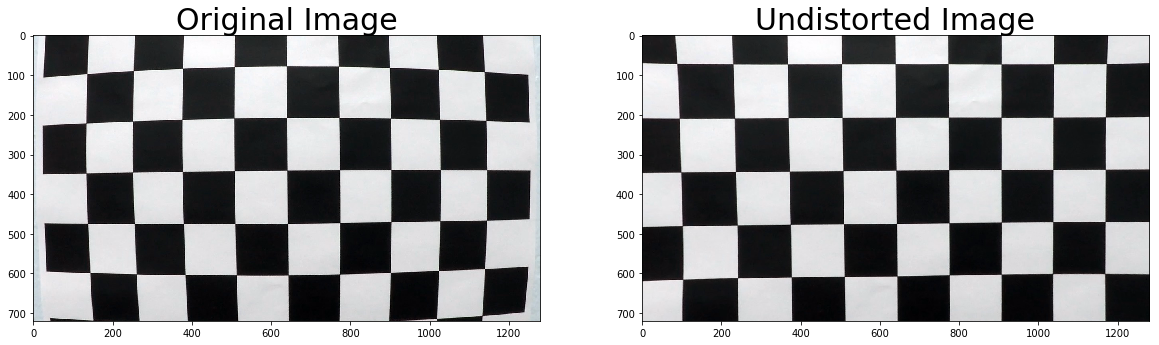

In [3]:
# Load mtx and dist from camera calibration pickle file
with open("camera_cal/camera_cal_pickle.p", mode='rb') as f:
    data = pickle.load(f)
    mtx = data['mtx']
    dist = data['dist']

# Function to undistort image based on camera calibration
def undistort_image (img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    
# Visualize undistortion
img_test = cv2.imread('camera_cal/calibration1.jpg')
undist_test = undistort_image(img_test)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_test)
ax2.set_title('Undistorted Image', fontsize=30)

## 3. Apply color and gradient thresholds
### Threshold functions with binary outputs

In [4]:
# HLS color space transformation based on channel and threshold
def hls_thresh(img, chan=2, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_chan = hls[:,:,chan]
    binary_output = np.zeros_like(hls_chan)
    binary_output[(hls_chan > thresh[0]) & (hls_chan <= thresh[1])] = 1
    return binary_output

# CIELAB color space transformation based on channel and threshold
def lab_thresh(img, chan=2, thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_chan = lab[:,:,chan]
    binary_output = np.zeros_like(lab_chan)
    binary_output[(lab_chan > thresh[0]) & (lab_chan <= thresh[1])] = 1
    return binary_output

# HSV color space transformation based on channel and threshold
def hsv_thresh(img, chan=2, thresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_chan = hsv[:,:,chan]
    binary_output = np.zeros_like(hsv_chan)
    binary_output[(hsv_chan > thresh[0]) & (hsv_chan <= thresh[1])] = 1
    return binary_output

# Define a function that takes an image, gradient orientation, 
# and threshold min / max values.
# Applies to either x gradient or y gradient
def grad_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
# Combines x and y gradients
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
# Based on gradient direction
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

### Test images

In [5]:
image0 = mpimg.imread('test_images/straight_lines1.jpg')
image1 = mpimg.imread('test_images/straight_lines2.jpg')
image2 = mpimg.imread('test_images/test1.jpg')
image3 = mpimg.imread('test_images/test5.jpg')
image4 = mpimg.imread('test_images/test4.jpg')

### Test HLS color threshold

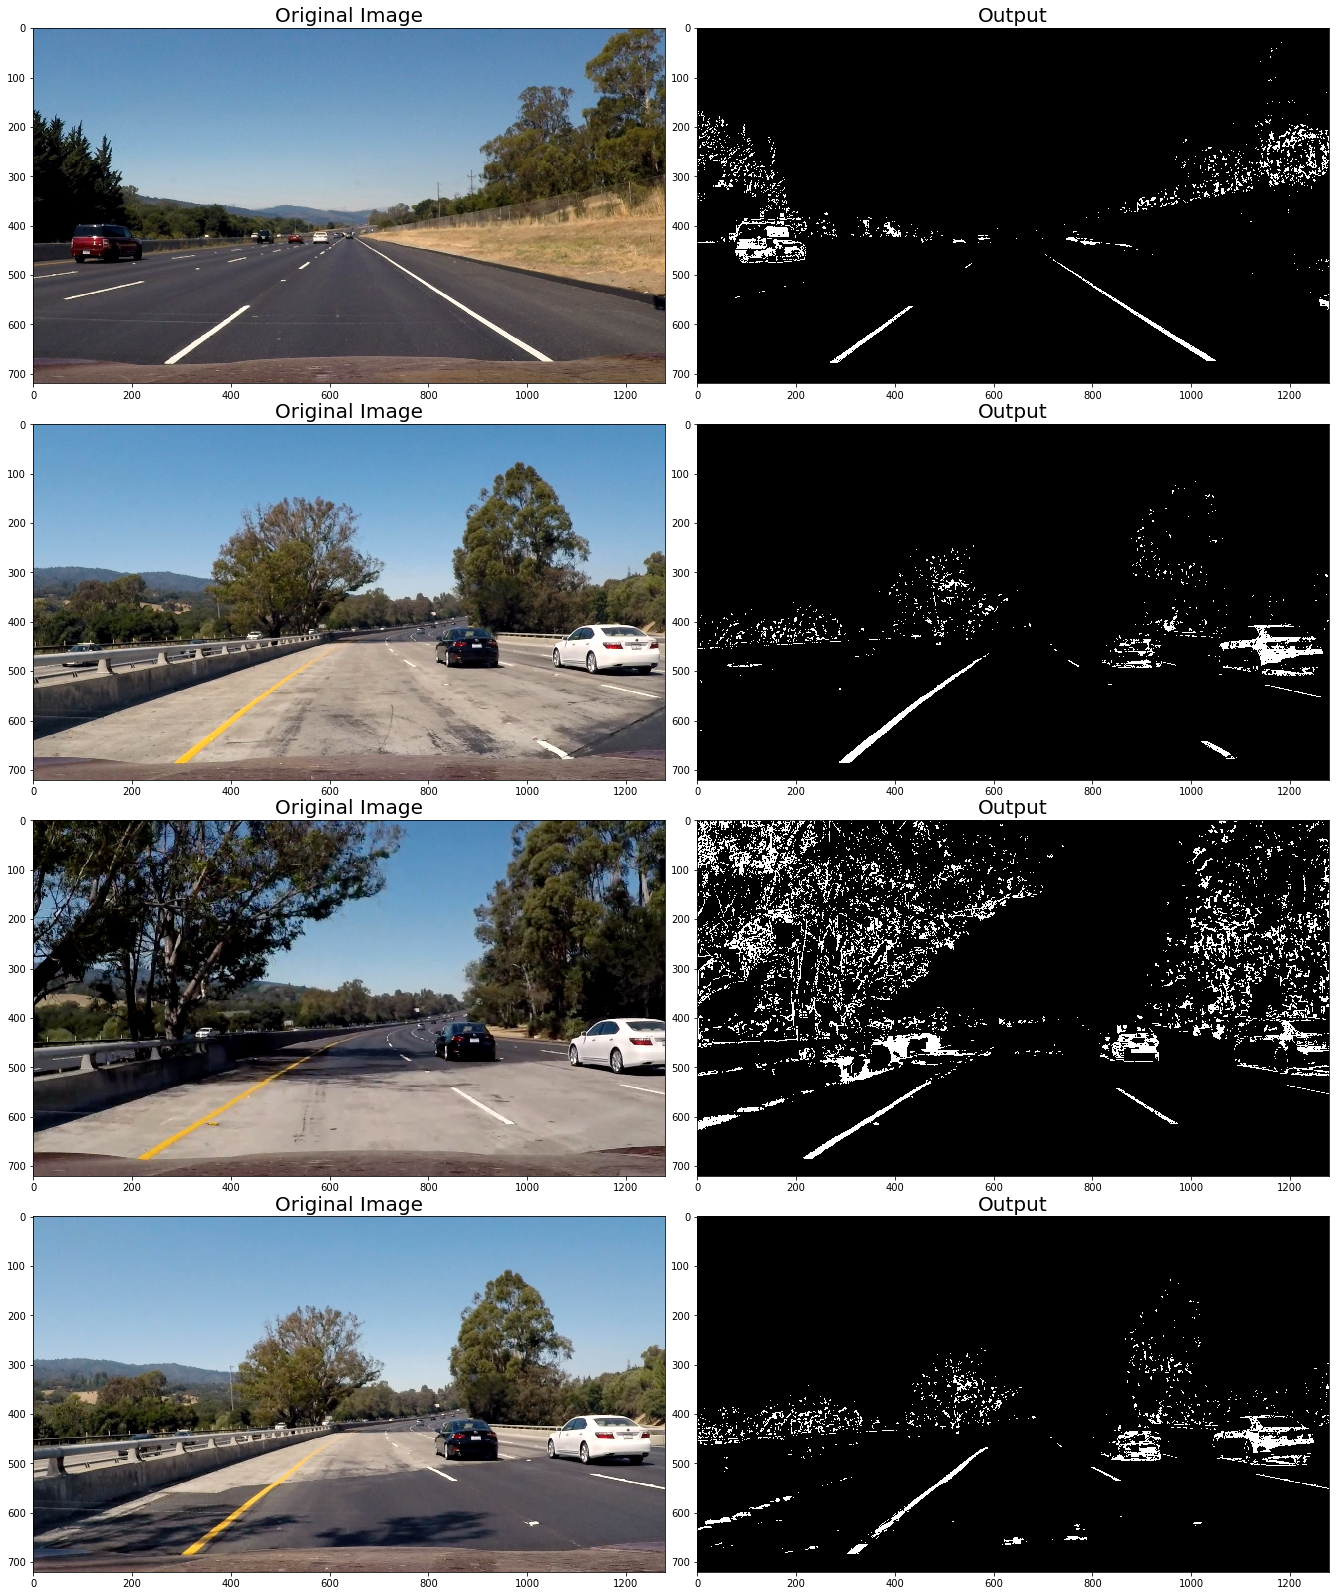

In [6]:
thresh = (155, 255)
hls_binary1 = hls_thresh(image1, chan=2, thresh=thresh)
hls_binary2 = hls_thresh(image2, chan=2, thresh=thresh)
hls_binary3 = hls_thresh(image3, chan=2, thresh=thresh)
hls_binary4 = hls_thresh(image4, chan=2, thresh=thresh)

# Plot the result for x gradient
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(24, 24))
f.tight_layout()

ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hls_binary1, cmap='gray')
ax2.set_title('Output', fontsize=20)

ax3.imshow(image2)
ax3.set_title('Original Image', fontsize=20)
ax4.imshow(hls_binary2, cmap='gray')
ax4.set_title('Output', fontsize=20)

ax5.imshow(image3)
ax5.set_title('Original Image', fontsize=20)
ax6.imshow(hls_binary3, cmap='gray')
ax6.set_title('Output', fontsize=20)

ax7.imshow(image4)
ax7.set_title('Original Image', fontsize=20)
ax8.imshow(hls_binary4, cmap='gray')
ax8.set_title('Output', fontsize=20)
plt.subplots_adjust(left=0., right=0.75, top=0.9, bottom=0.0)

### Sobel x gradient threshold

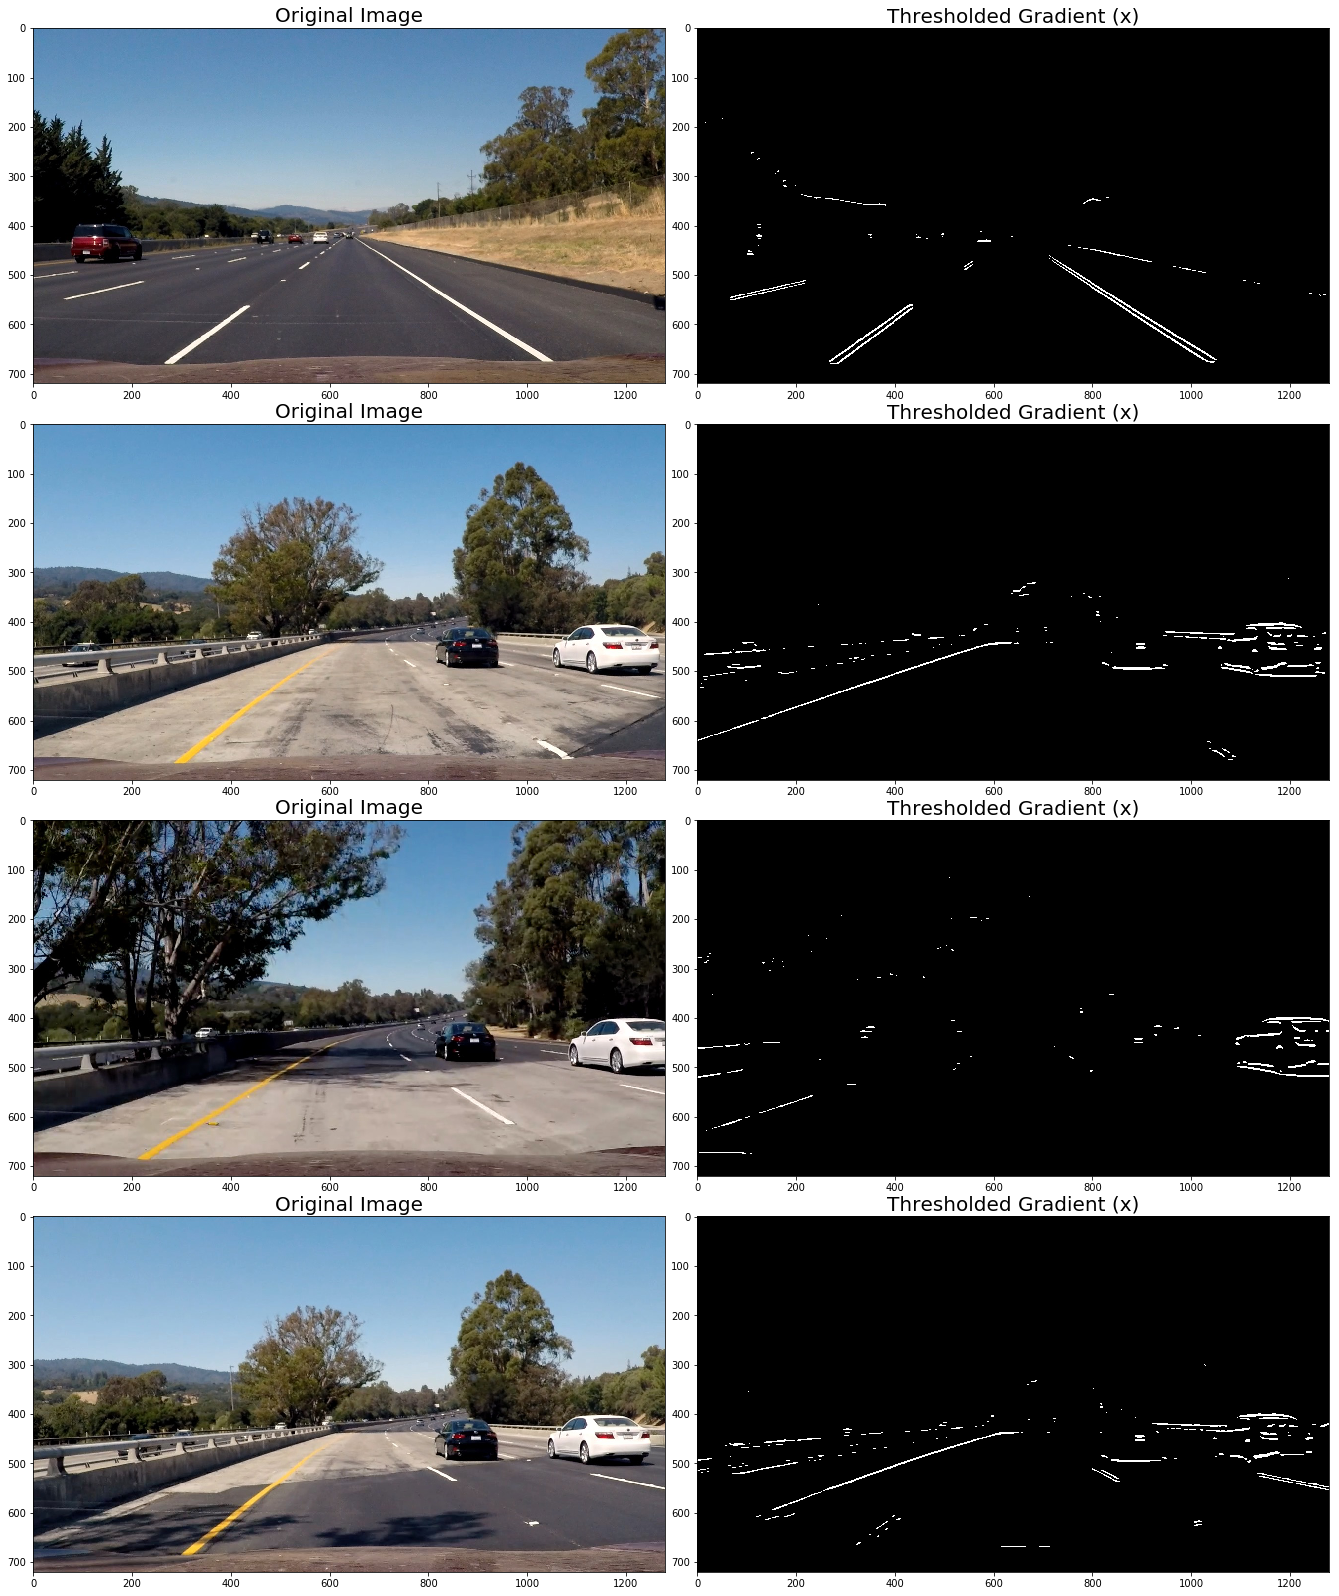

In [7]:
#kernel = 21
#thresh = (30, 90)
kernel = 21
thresh = (120, 255)
gradx_binary1 = grad_thresh(image1, orient='y', sobel_kernel=kernel, thresh=thresh)
gradx_binary2 = grad_thresh(image2, orient='y', sobel_kernel=kernel, thresh=thresh)
gradx_binary3 = grad_thresh(image3, orient='y', sobel_kernel=kernel, thresh=thresh)
gradx_binary4 = grad_thresh(image4, orient='y', sobel_kernel=kernel, thresh=thresh)

# Plot the result for x gradient
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(24, 24))
f.tight_layout()

ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gradx_binary1, cmap='gray')
ax2.set_title('Thresholded Gradient (x)', fontsize=20)

ax3.imshow(image2)
ax3.set_title('Original Image', fontsize=20)
ax4.imshow(gradx_binary2, cmap='gray')
ax4.set_title('Thresholded Gradient (x)', fontsize=20)

ax5.imshow(image3)
ax5.set_title('Original Image', fontsize=20)
ax6.imshow(gradx_binary3, cmap='gray')
ax6.set_title('Thresholded Gradient (x)', fontsize=20)

ax7.imshow(image4)
ax7.set_title('Original Image', fontsize=20)
ax8.imshow(gradx_binary4, cmap='gray')
ax8.set_title('Thresholded Gradient (x)', fontsize=20)
plt.subplots_adjust(left=0., right=0.75, top=0.9, bottom=0.0)

### Final binary outputs

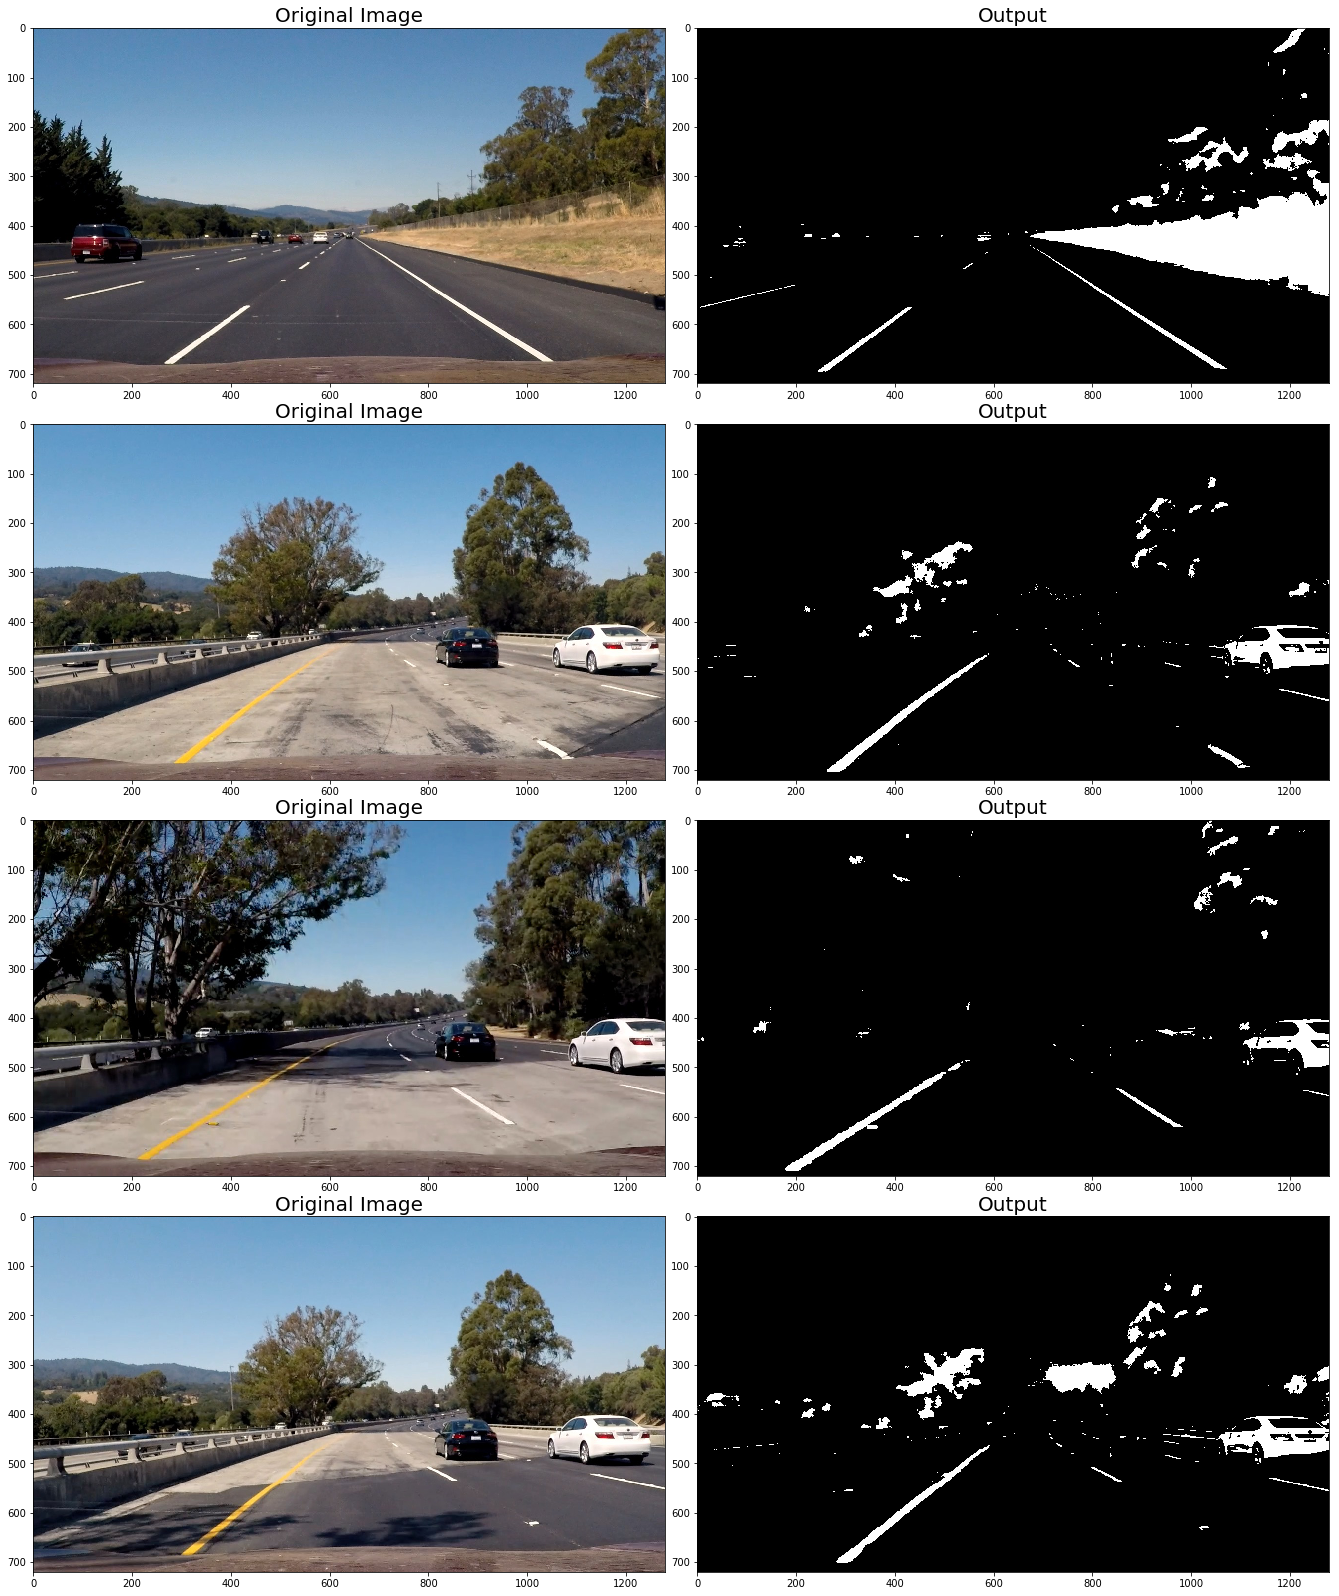

In [8]:
def final_binary (undist):
    binary_output = np.zeros_like(undist[:,:,0])
    #lab1 = lab_thresh(image, chan=2, thresh=(165, 205))
    #lab2 = lab_thresh(image, chan=0, thresh=(215, 255))
    lab1 = lab_thresh(undist, chan=2, thresh=(150, 255))
    lab2 = lab_thresh(undist, chan=0, thresh=(215, 255))
    #gradx = grad_thresh(image, sobel_kernel=21, thresh=(30, 90))
    #binary_output[(lab1==1) | (lab2==1) | (gradx==1)] = 1
    binary_output[(lab1==1) | (lab2==1)] = 1
    return binary_output

final_binary0 = final_binary(undistort_image(image0))
final_binary1 = final_binary(undistort_image(image1))
final_binary2 = final_binary(undistort_image(image2))
final_binary3 = final_binary(undistort_image(image3))
final_binary4 = final_binary(undistort_image(image4))

# Plot the result for x gradient
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(24, 24))
f.tight_layout()

ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(final_binary1, cmap='gray')
ax2.set_title('Output', fontsize=20)

ax3.imshow(image2)
ax3.set_title('Original Image', fontsize=20)
ax4.imshow(final_binary2, cmap='gray')
ax4.set_title('Output', fontsize=20)

ax5.imshow(image3)
ax5.set_title('Original Image', fontsize=20)
ax6.imshow(final_binary3, cmap='gray')
ax6.set_title('Output', fontsize=20)

ax7.imshow(image4)
ax7.set_title('Original Image', fontsize=20)
ax8.imshow(final_binary4, cmap='gray')
ax8.set_title('Output', fontsize=20)
plt.subplots_adjust(left=0., right=0.75, top=0.9, bottom=0.0)

## 4. Apply perspective transform

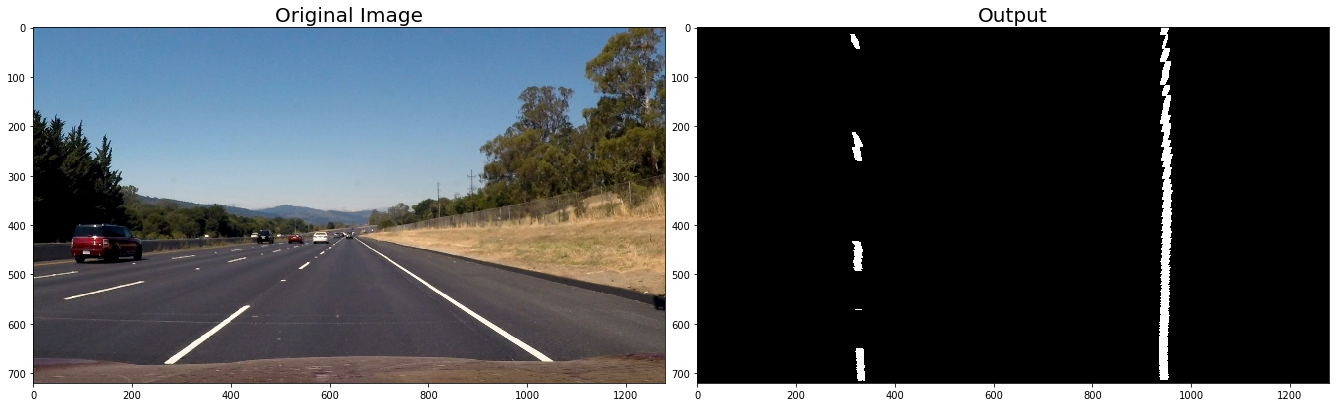

In [9]:
#src = np.float32(((600,445), (200,720), (1130,720), (682,445)))
#dst = np.float32(((320,0), (320,720), (960,720), (960,0)))
src = np.float32(((602,445), (200,720), (1130,720), (682,445)))
dst = np.float32(((320,0), (320,720), (960,720), (960,0)))
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warp_image (undist):
    img_size = (undist.shape[1], undist.shape[0])
    return cv2.warpPerspective(undist, M, img_size)

test_image = image1
binary_warped = warp_image(final_binary(undistort_image(test_image)))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Output', fontsize=20)
plt.subplots_adjust(left=0., right=0.75, top=0.9, bottom=0.0)

## 5. Detect lane lines
### Implement sliding window search

In [10]:
# Sliding window search to find lane lines
# Assuming you have created a warped binary image called "binary_warped"
def window_search(binary_warped, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy

### Visualize sliding window search

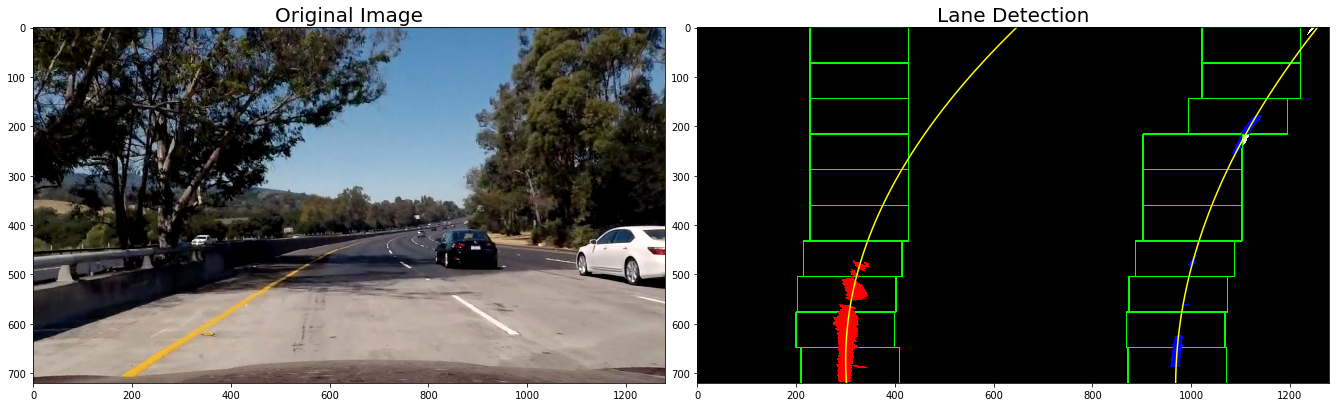

In [11]:
undist = undistort_image(image3)
binary_warped = warp_image(final_binary(undist))
out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = window_search(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Lane Detection', fontsize=20)
plt.subplots_adjust(left=0., right=0.75, top=0.9, bottom=0.0)

### Search based on previous fit

In [12]:
# Used with existing best fit lines and new binary_warped image
def fit_based_search (binary_warped, left_fit, right_fit, margin=100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy

### Visualize previous fit based search

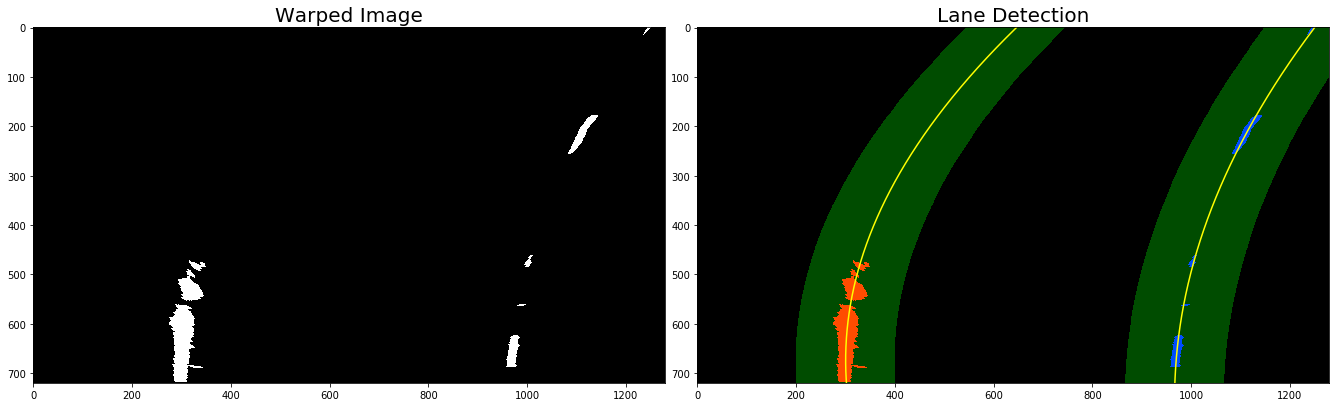

In [13]:
margin = 100
binary_warped = warp_image(final_binary(undistort_image(image3)))
out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = fit_based_search(binary_warped, left_fit, right_fit, margin)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
window_img = np.zeros_like(out_img)
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot binary_warped image and result image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Warped Image', fontsize=20)
ax2.imshow(result)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Lane Detection', fontsize=20)
plt.subplots_adjust(left=0., right=0.75, top=0.9, bottom=0.0)

### Drawing lane onto original image

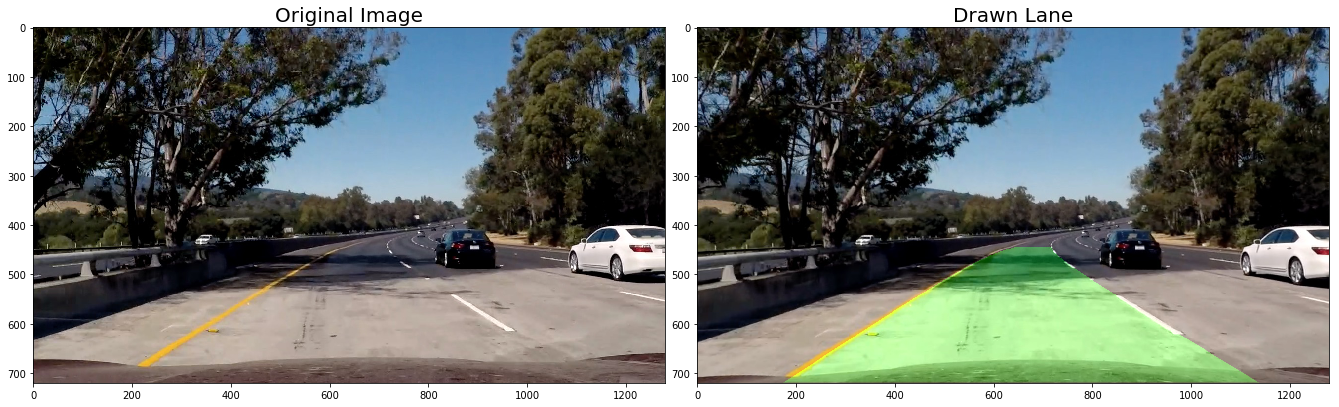

In [14]:
def draw_lane(undist, left_fit, right_fit, Minv):
    binary_warped = warp_image(final_binary(undist))
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image3)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(draw_lane(undistort_image(image3), left_fit, right_fit, Minv))
ax2.set_title('Drawn Lane', fontsize=20)
plt.subplots_adjust(left=0., right=0.75, top=0.9, bottom=0.0)

## 6. Determine lane curvature

In [15]:
def lane_curvature(left_fit, right_fit, ploty):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def real_lane_curvature(left_fit, right_fit, ploty):
    # Define conversions in x and y from pixels space to meters
    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

print("curvature in pixels:", lane_curvature(left_fit, right_fit, ploty))
print("curvature in meters:", real_lane_curvature(left_fit, right_fit, ploty))

curvature in pixels: (661.58176551282781, 1002.5369873260194)
curvature in meters: (215.81452394937148, 328.71526073915862)


### Determine car's offset relative to lane's center

In [16]:
# Returns the car's offset from lane center based on best fit lines
# Positive offset means car's position is right of center
def car_offset (undist, left_fit, right_fit):
    y_max = undist.shape[0]
    leftx_y_max = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    rightx_y_max = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    lane_center = (leftx_y_max + rightx_y_max) / 2
    offset = undist.shape[1]/2 - lane_center
    return offset * xm_per_pix

undist = undistort_image(image3)
print("offset in meters:", car_offset(undist, left_fit, right_fit))

offset in meters: 0.0290232207464
